In [1]:
import torch
import torch.nn as nn
import numpy as np
from tqdm import tqdm
from keras.datasets.mnist import load_data
from matplotlib import pyplot as plt

from DiffusionModel import DiffusionModel
from unet import UNet 

In [2]:
(trainX, trainY), (testX, testY) = load_data()

trainX = np.float32(trainX) / 255.
testX = np.float32(testX) / 255.


def sample_batch(batch_size, device):

    indices = torch.randperm(trainX.shape[0])[:batch_size]
    data = torch.from_numpy(trainX[indices]).unsqueeze(1).to(device) # [B, 1, H, W]
    
    return torch.nn.functional.interpolate(data, 32)

In [3]:
device = 'cuda'
model = torch.load('model_paper2_epoch_39999').to(device)
diffusion_model = DiffusionModel(1000, model, device)

In [4]:
def forward(diffusion_model, T, x0):

    x_forward = []
    x = x0

    for t in range(T):
        std = torch.sqrt(diffusion_model.beta[t])
        x = x + torch.randn_like(x) * std
        x_forward.append(x)

    return x_forward

In [5]:
@torch.no_grad()
def inpainting(self, x0, mask):


    # Run the forward process
    x_forward = []
    x = x0

    for t in range(self.T):
        std = torch.sqrt(diffusion_model.beta[t])
        x = torch.sqrt(1 - diffusion_model.beta[t]) * x + torch.randn_like(x) * std
        x_forward.append(x)

    x = x_forward[-1]
    

    for t in tqdm(range(self.T, 0, -1)):
        z = torch.randn_like(x) if t > 1 else torch.zeros_like(x)

        t_tensor = torch.ones(x0.shape[0], dtype=torch.long, device=self.device) * t

        beta_t = self.beta[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 
        alpha_t = self.alpha[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 
        alpha_bar_t = self.alpha_bar[t-1].unsqueeze(-1).unsqueeze(-1) .unsqueeze(-1) 

        mean = 1 / torch.sqrt(alpha_t) * (x - ((1 - alpha_t) / torch.sqrt(1 - alpha_bar_t)) * self.function_aproximator(x, t_tensor-1))
        sigma = torch.sqrt(beta_t)

        x = x_forward[t-1]
        x[mask] =( mean + sigma * z)[mask]

    return x

In [6]:
x0 = sample_batch(10, device)

100%|██████████| 1000/1000 [00:30<00:00, 32.57it/s]


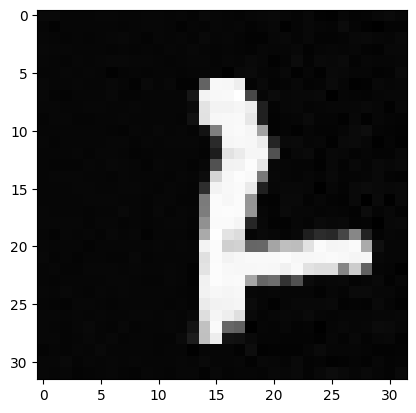

In [7]:
mask = torch.zeros_like(x0).bool()
mask[:,:,:,:18] = 1.
x = inpainting(diffusion_model, x0, mask)
plt.imshow(x[0, 0].data.cpu().numpy(), cmap='gray')
plt.show()
# x_star = x.clone()
# x[mask] = 0.5
# plt.imshow(x[0, 0].data.cpu().numpy(), cmap='gray')

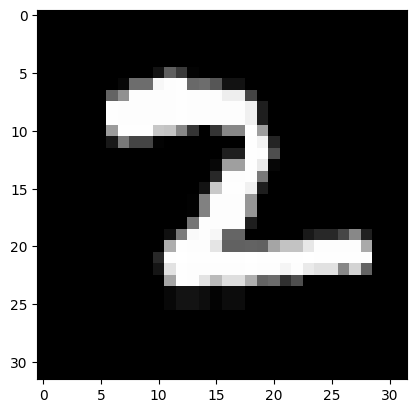

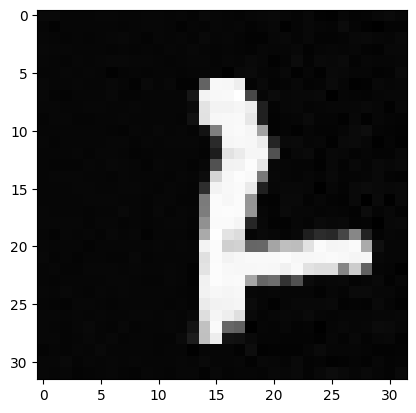

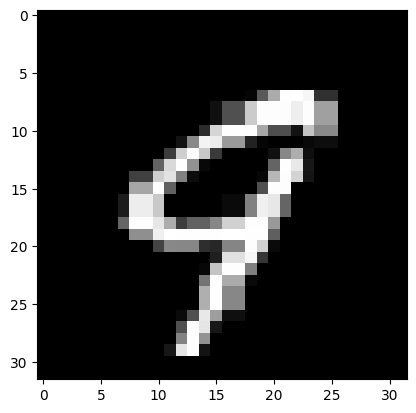

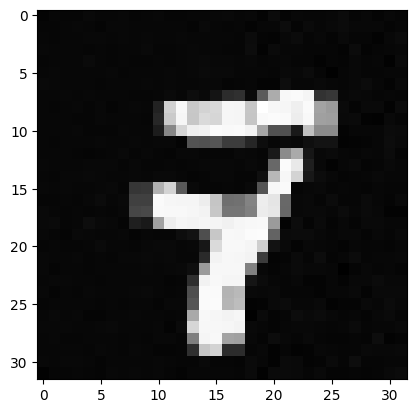

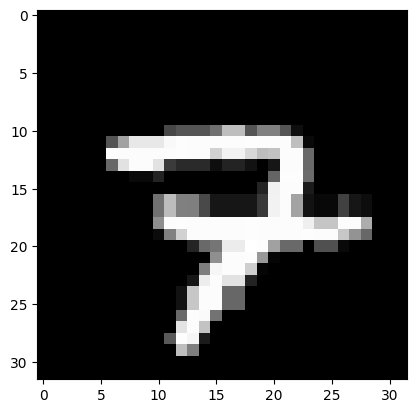

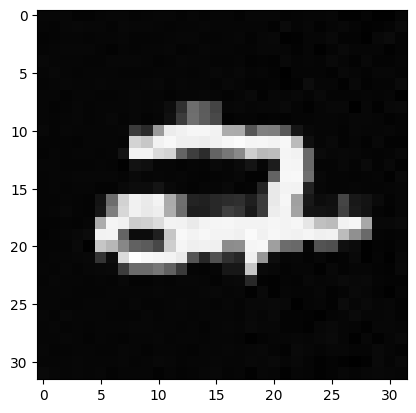

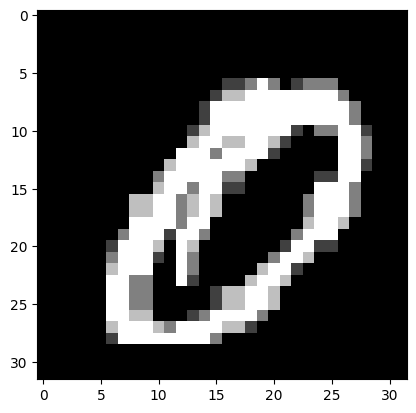

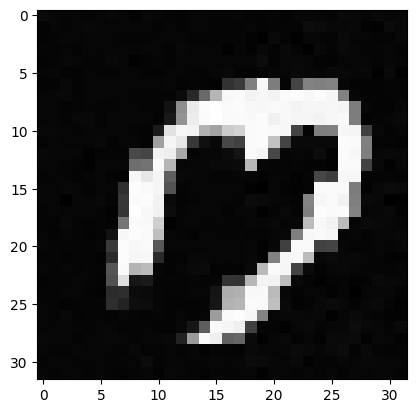

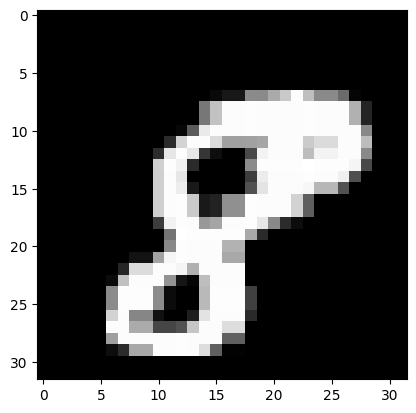

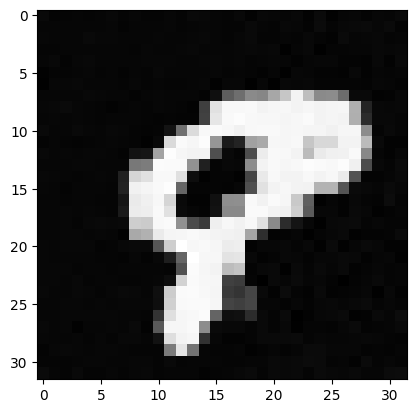

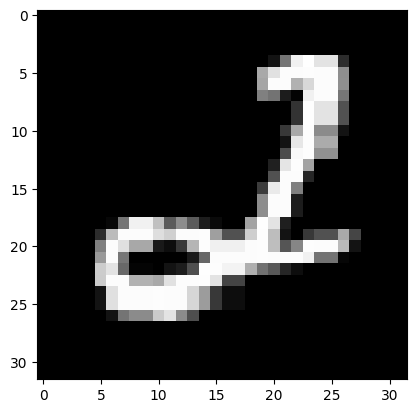

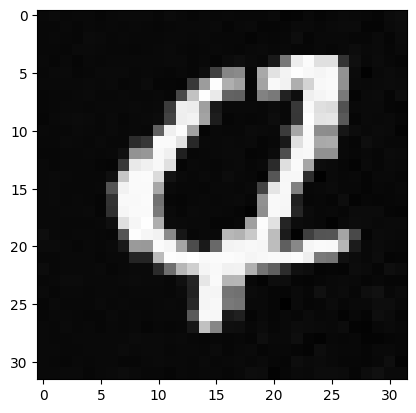

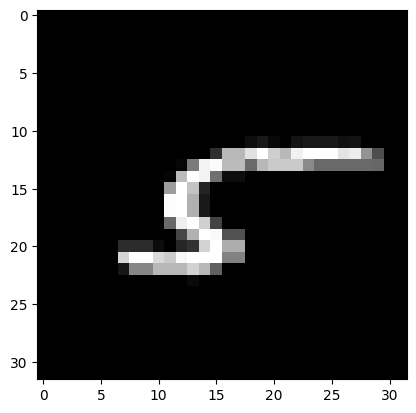

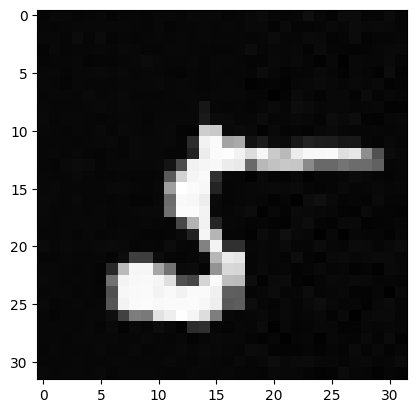

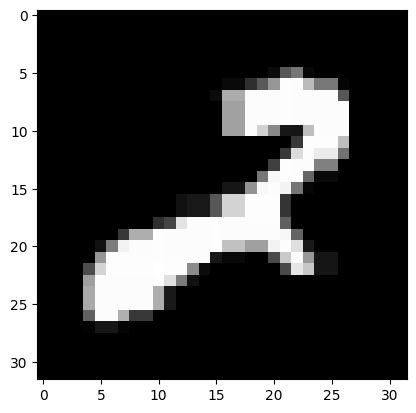

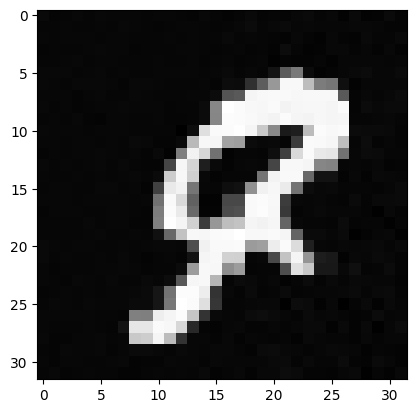

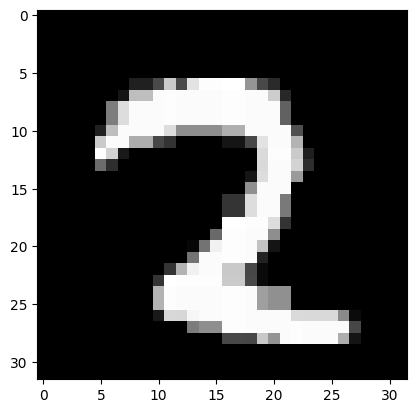

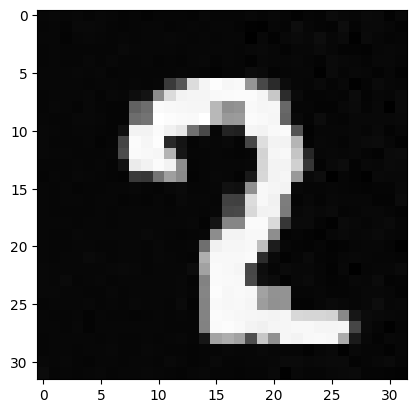

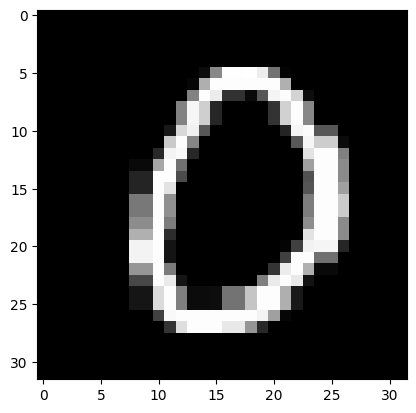

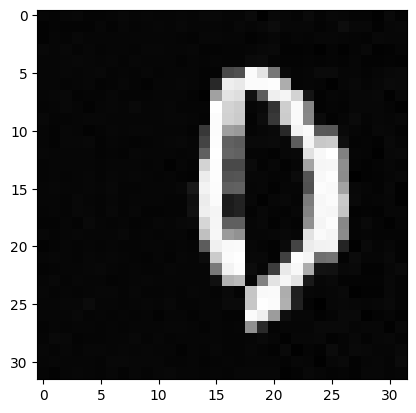

In [8]:
for i in range(10):
    plt.imshow(x0[i, 0].data.cpu().numpy(), cmap='gray')
    plt.show()
    plt.imshow(x[i, 0].data.cpu().numpy(), cmap='gray')
    plt.show()
    print()